In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy.ndimage import shift
from cycler import cycler
import seaborn as sb

plt.rcParams['figure.figsize'] = [10, 5]

def smooth(y, window_size):
    box = np.ones(window_size)/window_size
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def plot_compute_time(ax, exp_name, exp_id, num_drones, sync_window, phy_step_size, net_step_size, smooth_window=0):

    net_sync_factor = int(sync_window/net_step_size)

    # Network simulator
    data = "../data/"+exp_name+"/network_sim_data"+str(exp_id)+".csv"
    comp_time_net_us = pd.read_csv(data)["Time[us]"]
    cumul_window = []
    for i in range(int(comp_time_net_us.size/net_sync_factor)+1):
        cumul_window.append(np.sum(comp_time_net_us[net_sync_factor*i:net_sync_factor*(i+1)]))
    ns3_rtf = np.divide(cumul_window, sync_window)

    # Robotics simulator
    data = "../data/"+exp_name+"/robot_sim_data"+str(exp_id)+".csv"
    comp_time_rob_us = pd.read_csv(data)["Time[us]"]
    gazebo_rtf = np.divide(comp_time_rob_us, sync_window)

    # Coordinator
    data = "../data/"+exp_name+"/coordinator"+str(exp_id)+".csv"
    iteration_time_us = pd.read_csv(data)["Time[us]"]
    iteration_time_us = list(iteration_time_us)
    iteration_time_us = shift(iteration_time_us, -1, cval=0)
    overhead = []
    for i in range(0, len(iteration_time_us)):
        overhead.append(iteration_time_us[i] - max((comp_time_rob_us[i], cumul_window[i])))
    overhead = np.divide(overhead, sync_window)
    iteration_time_us = np.divide(iteration_time_us, sync_window)
    
    x = np.arange(0, len(iteration_time_us))
    x = np.multiply(x, sync_window*1e-6) # convert to seconds
        
    assert(len(ns3_rtf) == len(gazebo_rtf))
    assert(len(ns3_rtf) == len(overhead))
    assert(len(ns3_rtf) == len(iteration_time_us))
    assert(len(ns3_rtf) == len(x))
    
    ys = [ns3_rtf, gazebo_rtf, iteration_time_us, overhead]
    
    markers=['o', 'v', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X', 'x', '^', '+', '1', '2', '3', '4', '8', '|', '_', '.', ',']
    styles = cycler(
        color=sb.color_palette(palette='Set2', n_colors=4),
        marker = markers[:4],
    )
    
    if smooth_window > 0:
        ys = [smooth(y, smooth_window) for y in ys]
    
    for style, y in zip(styles, ys):
            ax.plot(x, y, linewidth=1.5, markersize=7, markerfacecolor='none', markevery=200, **style)
            
    # ax.set_title("Evaluation of co-simulation overhead compared to each simulator's computation time ("+str(num_drones)+" drones)")
    ax.set_xlabel("Simulation time (s)")
    ax.set_ylabel("Simulation Time Factor (STF)")

    # "real-time" line
    # ax.plot(x, np.full(x.size, 1.0), color='red', linestyle='dashed')

    lines = ax.get_lines()
    ax.legend((lines[0], lines[1], lines[2], lines[3]), ("ns-3", "Gazebo", "Co-simulator", "Overhead"))

    # print("Sync_window_size: "+str(sync_window))
    # print("Phy_step_size: "+str(phy_step_size))
    # print("Net_step_size: "+str(net_step_size))
    
    return ax

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
def grouped_bar_chart(ax, exp_name, exp_id, drone_number, sync_window, phy_step_size, net_step_size, start1=0, end1=None, start2=0, end2=None):
    
    net_sync_factor = int(sync_window/net_step_size)
        
    # Network simulator
    data = "../data/"+exp_name+"/network_sim_data"+str(exp_id)+".csv"
    comp_time_net_us = pd.read_csv(data)["Time[us]"]
    cumul_window = []
    for i in range(int(comp_time_net_us.size/net_sync_factor)+1):
        cumul_window.append(np.sum(comp_time_net_us[net_sync_factor*i:net_sync_factor*(i+1)]))
    cumul_window = np.divide(cumul_window, sync_window)

    # Robotics simulator
    data = "../data/"+exp_name+"/robot_sim_data"+str(exp_id)+".csv"
    comp_time_rob_us = pd.read_csv(data)["Time[us]"]
    comp_time_rob_us = np.divide(comp_time_rob_us, sync_window)
    
    # Coordinator
    data = "../data/"+exp_name+"/coordinator"+str(exp_id)+".csv"
    coord_time_us = pd.read_csv(data)["Time[us]"]
    coord_time_us = list(coord_time_us)
    coord_time_us = shift(coord_time_us, -1, cval=0) # The coordinator time is shifted because of the first iteration
    coord_time_us = np.divide(coord_time_us, sync_window)
    
    # Overhead
    overhead = []
    for i in range(0, len(coord_time_us)):
        overhead.append(coord_time_us[i] - max((comp_time_rob_us[i], cumul_window[i])))
    
    if end1 == None:
        end1 = min(coord_time_us.size, comp_time_rob_us.size, len(cumul_window))
    if end2 == None:
        end2 = min(coord_time_us.size, comp_time_rob_us.size, len(cumul_window))


    phases = ("Idle", "Flocking")
    x = np.arange(len(phases))
    compute_time_means = {
        'ns-3': (np.mean(cumul_window[start1 : end1]), np.mean(cumul_window[start2 : end2])),
        'Gazebo': (np.mean(comp_time_rob_us[start1 : end1]), np.mean(comp_time_rob_us[start2 : end2])),
        'Co-simulator': (np.mean(coord_time_us[start1 : end1]), np.mean(coord_time_us[start2 : end2])),
        'Overhead': (np.mean(overhead[start1 : end1]), np.mean(overhead[start2 : end2]))
    }
    
    colors=sb.color_palette(palette='Set2', n_colors=4)
    print(colors)

    width = 0.17
    multiplier = 0
    for module, value in compute_time_means.items():
        offset = multiplier * width
        rects = ax.bar(x + offset, value, width, label=module, color=colors[multiplier])
        # ax.bar_label(rects, padding=3)
        multiplier += 1
        
    # ax.bar(compute_time_means.keys(), compute_time_means.values(), width=1, color=['#1f77b4', '#ff7f0e', '#2ca02c']) #default colors of matplotlib
    
    ax.set_ylabel('Mean STF')
    # ax.set_title('Comparison of the co-simulator \nperformances depending on network activity')
    ax.set_xticks(x + 1.5*width, phases)
    ax.legend()

## Flocking example

**Parameters :**
|         Name        | ID | Drones | Iteration_size | PHY_step_size | NET_step_size | update_rate |
|:-------------------:|:--:|:------:|:--------------:|:-------------:|:-------------:|:-----------:|
| validation_flocking |  1 |    6   |      20 ms     |     10 ms     |      1 ms     |     400     |

Note : Le flocking se passe bien, GUI Gazebo activé, tout roule.

TypeError: grouped_bar_chart() got an unexpected keyword argument 'start'

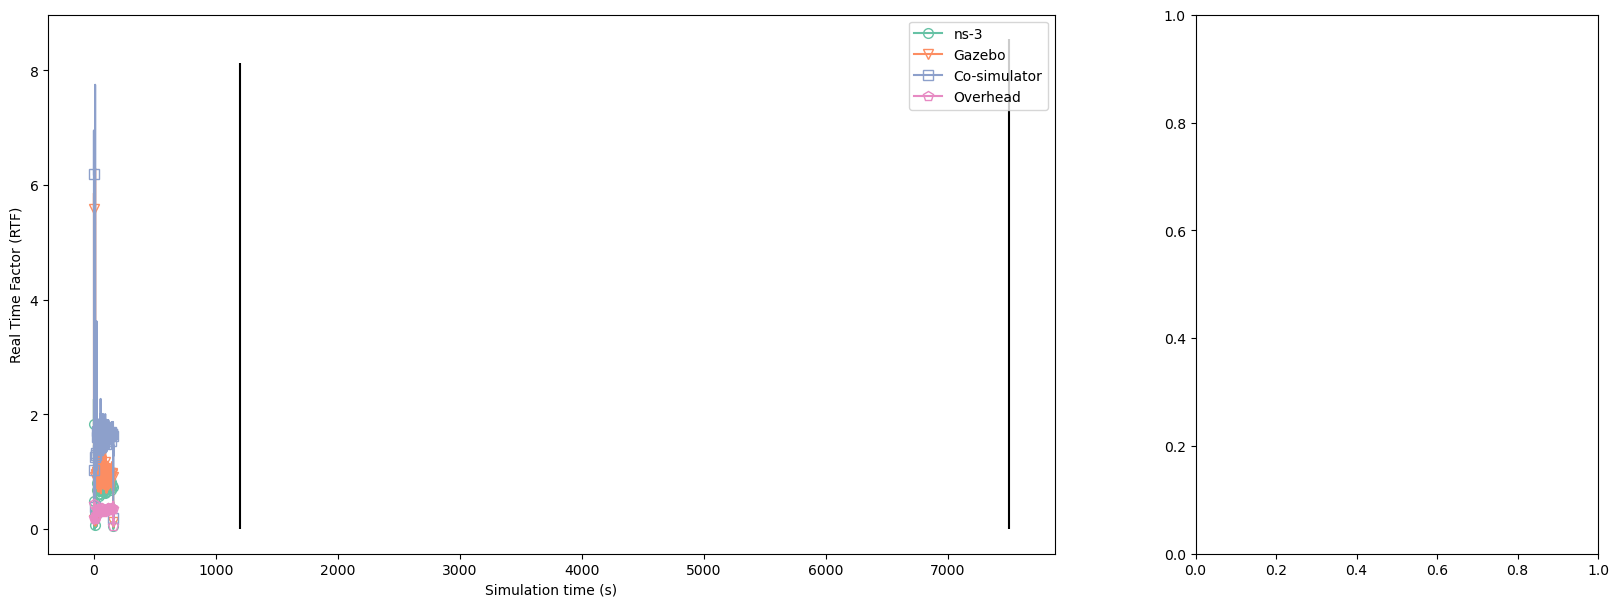

In [7]:
experience_name = "validation_flocking"
exp_id = 1
start = 1200
end = 7500

gs_kw = dict(width_ratios=[2.5, 1])

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,7), gridspec_kw=gs_kw)

plot_compute_time(ax1, experience_name, exp_id, 6, 20000, 10000, 1000, 20)
ax1.vlines(x=start, ymin=0, ymax=ax1.get_ylim()[1],  color='black')
ax1.vlines(x=end, ymin=0, ymax=ax1.get_ylim()[1],  color='black')
grouped_bar_chart(ax2, experience_name, exp_id, 6, 20000, 10000, 1000, start=start, end=end)

plt.show(fig)

**Parameters :**
|         Name        | ID | Drones | Iteration_size | PHY_step_size | NET_step_size | update_rate |
|:-------------------:|:--:|:------:|:--------------:|:-------------:|:-------------:|:-----------:|
| validation_flocking |  2 |    3   |      20 ms     |     10 ms     |      1 ms     |     400     |

Note : Tout roule aussi.

7226
7226
7226
7226
7226


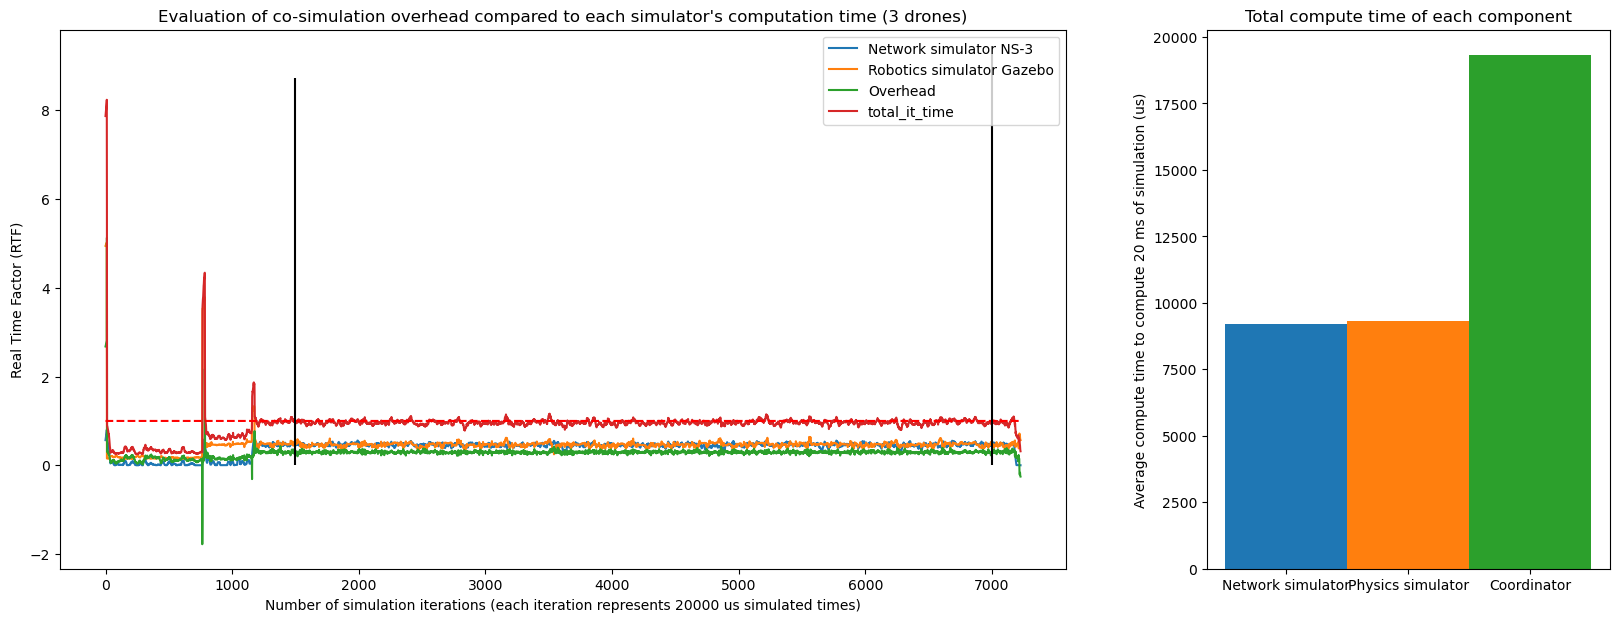

In [ ]:
experience_name = "validation_flocking"
exp_id = 2
start = 1500
end = 7000

gs_kw = dict(width_ratios=[2.5, 1])

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,7), gridspec_kw=gs_kw)

plot_compute_time(ax1, experience_name, exp_id, 3, 20000, 10000, 1000, 20)
ax1.vlines(x=start, ymin=0, ymax=ax1.get_ylim()[1],  color='black')
ax1.vlines(x=end, ymin=0, ymax=ax1.get_ylim()[1],  color='black')
grouped_bar_chart(ax2, experience_name, exp_id, 3, 20000, 10000, 1000, start=start, end=end)

plt.show(fig)

AttributeError: 'Cycler' object has no attribute 'get_next'

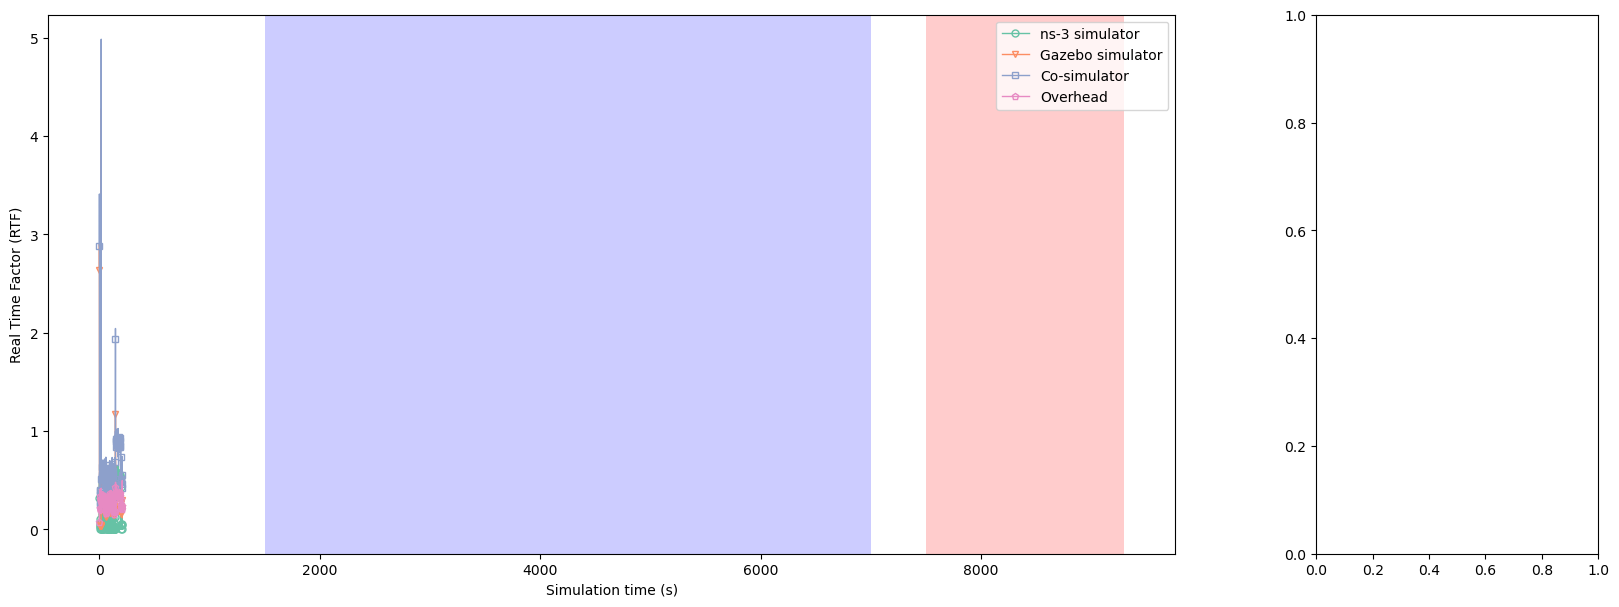

In [ ]:
experience_name = "validation_performance"
exp_id = 4
start1 = 1500
end1 = 7000
start2 = 7500
end2 = 9300

gs_kw = dict(width_ratios=[4, 1])

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,7), gridspec_kw=gs_kw)

plot_compute_time(ax1, experience_name, exp_id, 4, 20000, 10000, 1000, 20)
# ax1.vlines(x=start1, ymin=0, ymax=ax1.get_ylim()[1],  color='black')
# ax1.vlines(x=end1, ymin=0, ymax=ax1.get_ylim()[1],  color='black')
# ax1.vlines(x=start2, ymin=0, ymax=ax1.get_ylim()[1],  color='black')
# ax1.vlines(x=end2, ymin=0, ymax=ax1.get_ylim()[1],  color='black')

ax1.axvspan(start1, end1, facecolor='b', alpha=0.2)
ax1.axvspan(start2, end2, facecolor='r', alpha=0.2)


grouped_bar_chart(ax2, experience_name, exp_id, 4, 20000, 10000, 1000, start1=start1, end1=end1, start2=start2, end2=end2)

# ax1.set_xlim(7250,7300)
ax1.set_ylim(0,2)
plt.show(fig)

[(0.4, 0.7607843137254902, 0.6470588235294118), (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), (0.5529411764705883, 0.6274509803921569, 0.796078431372549), (0.9058823529411765, 0.5411764705882353, 0.7647058823529411)]


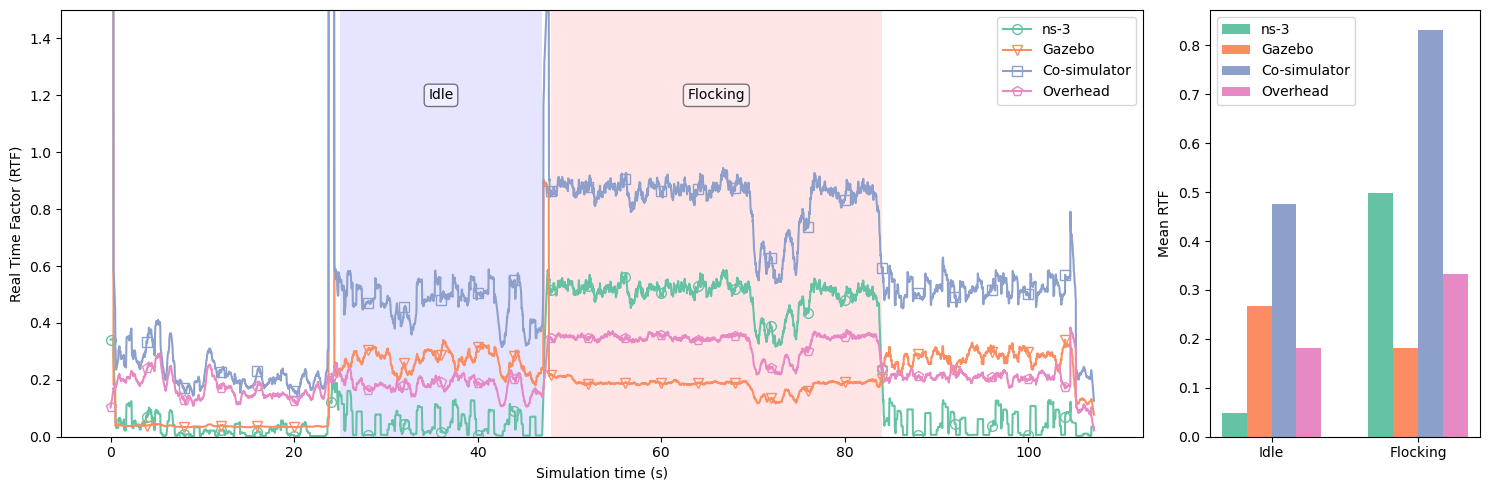

In [8]:
experience_name = "validation_performance"
exp_id = 5
start1 = 1250
end1 = 2350
start2 = 2400
end2 = 4200

gs_kw = dict(width_ratios=[4, 1])

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5), gridspec_kw=gs_kw)

plot_compute_time(ax1, experience_name, exp_id, 4, 20000, 10000, 1000, smooth_window=30)
# ax1.vlines(x=start1, ymin=0, ymax=ax1.get_ylim()[1],  color='black')
# ax1.vlines(x=end1, ymin=0, ymax=ax1.get_ylim()[1],  color='black')
# ax1.vlines(x=start2, ymin=0, ymax=ax1.get_ylim()[1],  color='black')
# ax1.vlines(x=end2, ymin=0, ymax=ax1.get_ylim()[1],  color='black')

grouped_bar_chart(ax2, experience_name, exp_id, 4, 20000, 10000, 1000, start1=start1, end1=end1, start2=start2, end2=end2)

start1 *= 20000*1e-6
end1 *= 20000*1e-6
start2 *= 20000*1e-6
end2 *= 20000*1e-6

ax1.axvspan(start1, end1, facecolor='b', alpha=0.1)
ax1.axvspan(start2, end2, facecolor='r', alpha=0.1)
props = dict(boxstyle='round', facecolor='ghostwhite', alpha=0.5)
ax1.text(x = start1+(end1-start1)/2, y = 1.2, s = "Idle", horizontalalignment='center', verticalalignment='center', bbox=props)
ax1.text(x = start2+(end2-start2)/2, y = 1.2, s = "Flocking", horizontalalignment='center', verticalalignment='center', bbox=props)


# fig.suptitle("Performance evaluation of the modules of the DANCERS co-simulator")
fig.tight_layout()

# ax1.set_xlim(21,24)
ax1.set_ylim(0,1.5)
plt.show(fig)

[(0.4, 0.7607843137254902, 0.6470588235294118), (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), (0.5529411764705883, 0.6274509803921569, 0.796078431372549), (0.9058823529411765, 0.5411764705882353, 0.7647058823529411)]
32.0 66.0 69.0 188.0


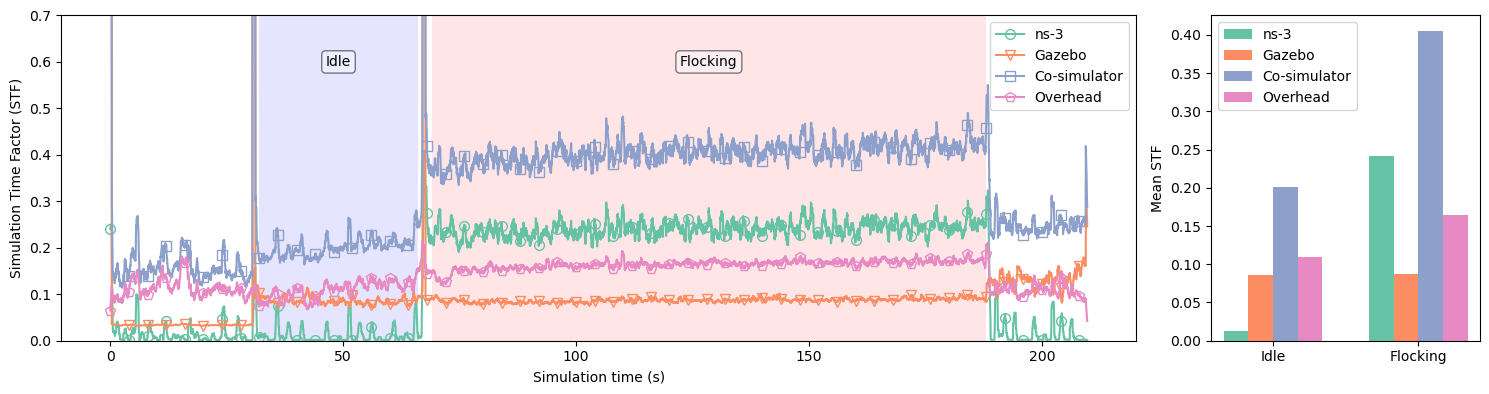

In [6]:
experience_name = "flocking_with_obstacles_3"
exp_id = 1
start1 = 1600
end1 = 3300
start2 = 3450
end2 = 9400

gs_kw = dict(width_ratios=[4, 1])

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,4), gridspec_kw=gs_kw)

plot_compute_time(ax1, experience_name, exp_id, 4, 20000, 10000, 1000, smooth_window=30)
# ax1.vlines(x=start1, ymin=0, ymax=ax1.get_ylim()[1],  color='black')
# ax1.vlines(x=end1, ymin=0, ymax=ax1.get_ylim()[1],  color='black')
# ax1.vlines(x=start2, ymin=0, ymax=ax1.get_ylim()[1],  color='black')
# ax1.vlines(x=end2, ymin=0, ymax=ax1.get_ylim()[1],  color='black')

grouped_bar_chart(ax2, experience_name, exp_id, 4, 20000, 10000, 1000, start1=start1, end1=end1, start2=start2, end2=end2)

start1 *= 20000*1e-6
end1 *= 20000*1e-6
start2 *= 20000*1e-6
end2 *= 20000*1e-6

print(start1, end1, start2, end2)

ax1.axvspan(start1, end1, facecolor='b', alpha=0.1)
ax1.axvspan(start2, end2, facecolor='r', alpha=0.1)
props = dict(boxstyle='round', facecolor='ghostwhite', alpha=0.5)
ax1.text(x = start1+(end1-start1)/2, y = 0.6, s = "Idle", horizontalalignment='center', verticalalignment='center', bbox=props)
ax1.text(x = start2+(end2-start2)/2, y = 0.6, s = "Flocking", horizontalalignment='center', verticalalignment='center', bbox=props)


# fig.suptitle("Performance evaluation of the modules of the DANCERS co-simulator")
fig.tight_layout()

# ax1.set_xlim(21,24)
ax1.set_ylim(0,0.7)
plt.show(fig)